### Experiments

#### Import Libraries

In [1]:
from utils.data_utils import split_dataset, TimeSeriesDataset
from utils.evaluation_utils import plot_multistep_forecast
from utils.training_utils import train
import pandas as pd 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Import Data

In [3]:
ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
training_df, test_df = split_dataset(ETTm2, remain_same = False)

#### Multivariate Case

#### Global Parameters

In [4]:
p_lag = 96
future_steps = 48
batch_size = 8
epochs = 8
learning_rate=1.e-4
decomp_kernel_size = 24
number_of_forecasts = 100
target_column = ['OT']
feature_columns = [i for i in training_df.columns]
modelling_task = 'univariate'
n_continous_features=7
n_categorial_features=5
dataset_name = 'ETTm2'

#### ETTm2

#### RLinear

Random seed set as 42
Univatiate modelling
inflation factor = 1
Rlinear activated
Points to be estimated


Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 23.82920990638733
Current (running) training loss at iteration 10000 : 21.887240492248534
Current (running) training loss at iteration 15000 : 17.716369768587747
Current (running) training loss at iteration 20000 : 15.104328050768375
Current (running) training loss at iteration 25000 : 13.626732208909988
Current (running) training loss at iteration 30000 : 12.711219569166502
Current (running) training loss at iteration 35000 : 11.879503637157168
Current (running) training loss at iteration 40000 : 10.96457395401001
Current (running) training loss at iteration 45000 : 10.313267309300105

Epoch 0: 

Train metrics: -------
Running (training) loss is 10.059522765942248.
Training MAE is 0.821851347385816.
Training MSE is 10.127716940119685.

Test metrics: -------
Running (test) loss is 9.871527064180055.
Test MAE is 0.8462866343070218.
Test MSE is 9.945014457732837.
------------

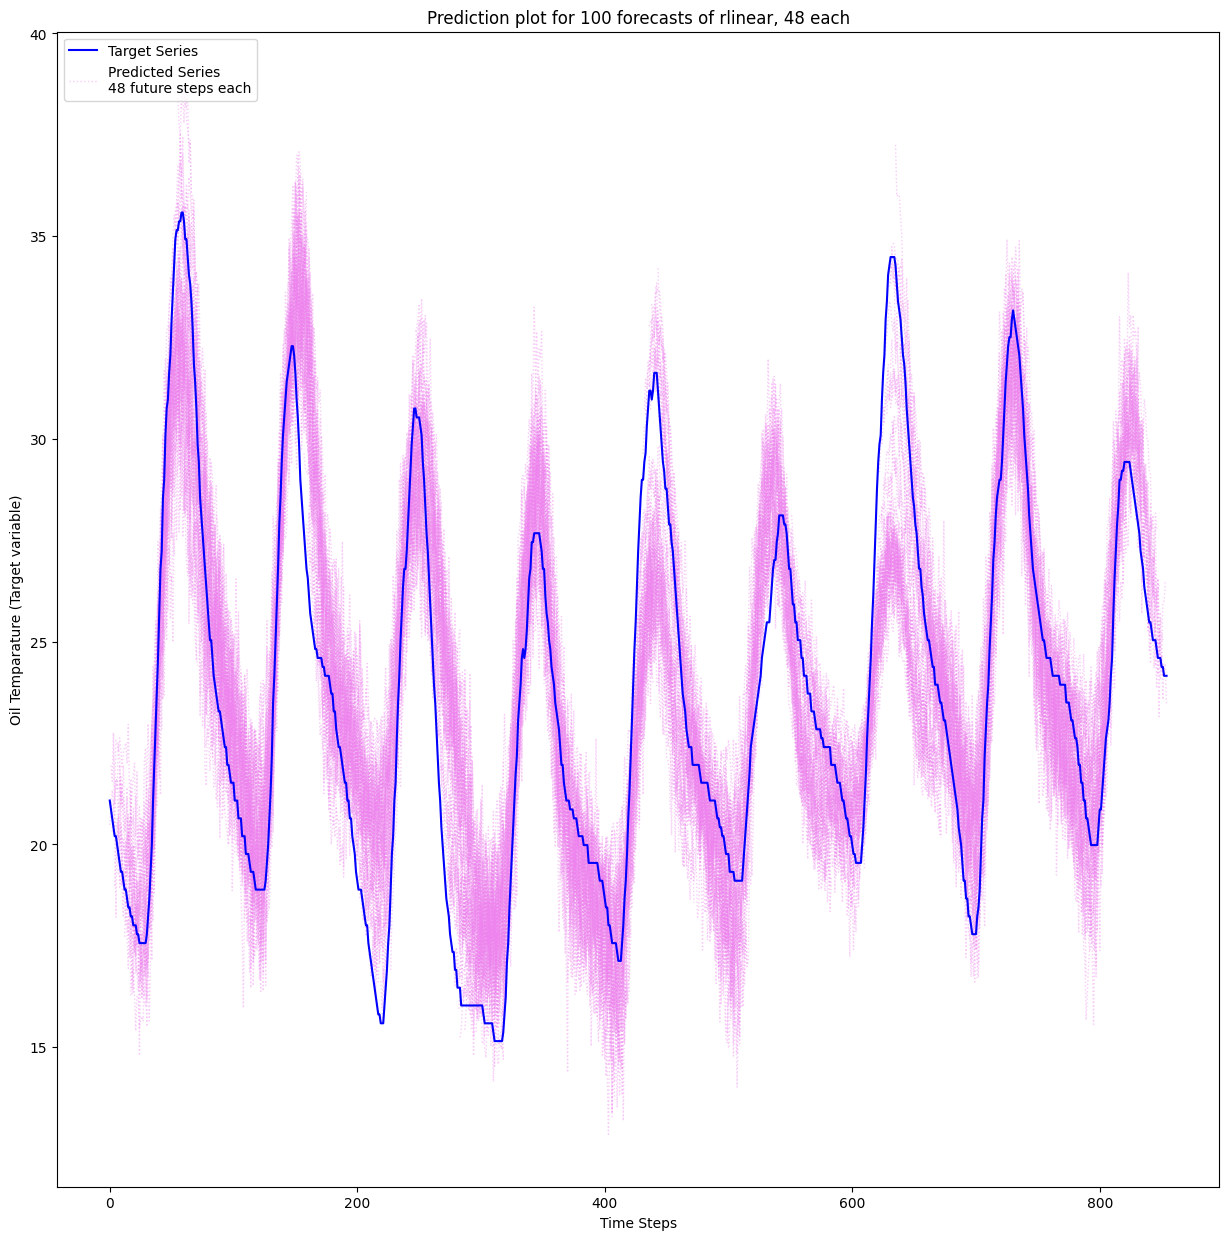

In [5]:
net = train(
            epochs = epochs, 
            n_continous_features=n_continous_features, 
            n_categorial_features=n_categorial_features,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = test_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            model = 'rlinear', 
            modelling_task = modelling_task, 
            dataset_name = dataset_name
            )
test_data = DataLoader(TimeSeriesDataset(test_df, future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, dataset_name = dataset_name, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)

#### Dlinear

Random seed set as 42
Univatiate modelling
inflation factor = 1
Dlinear activated
Points to be estimated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 18.58944076385498
Current (running) training loss at iteration 10000 : 15.547907088088989
Current (running) training loss at iteration 15000 : 13.119651695251465
Current (running) training loss at iteration 20000 : 11.746393889236451
Current (running) training loss at iteration 25000 : 10.811766997680664
Current (running) training loss at iteration 30000 : 10.833990987968445
Current (running) training loss at iteration 35000 : 10.673419879095896
Current (running) training loss at iteration 40000 : 10.18380974984169
Current (running) training loss at iteration 45000 : 9.658825986777412

Epoch 0: 

Train metrics: -------
Running (training) loss is 9.458124936382507.
Training MAE is 0.8483734112481787.
Training MSE is 9.52397437608581.

Test metrics: -------
Running (test) loss is 58.5419759676542.
Test MAE is 2.223227649360874.
Test MSE is 58.617799635423395.
---------------------------
Current learning rate is : 5e-05
-----------------

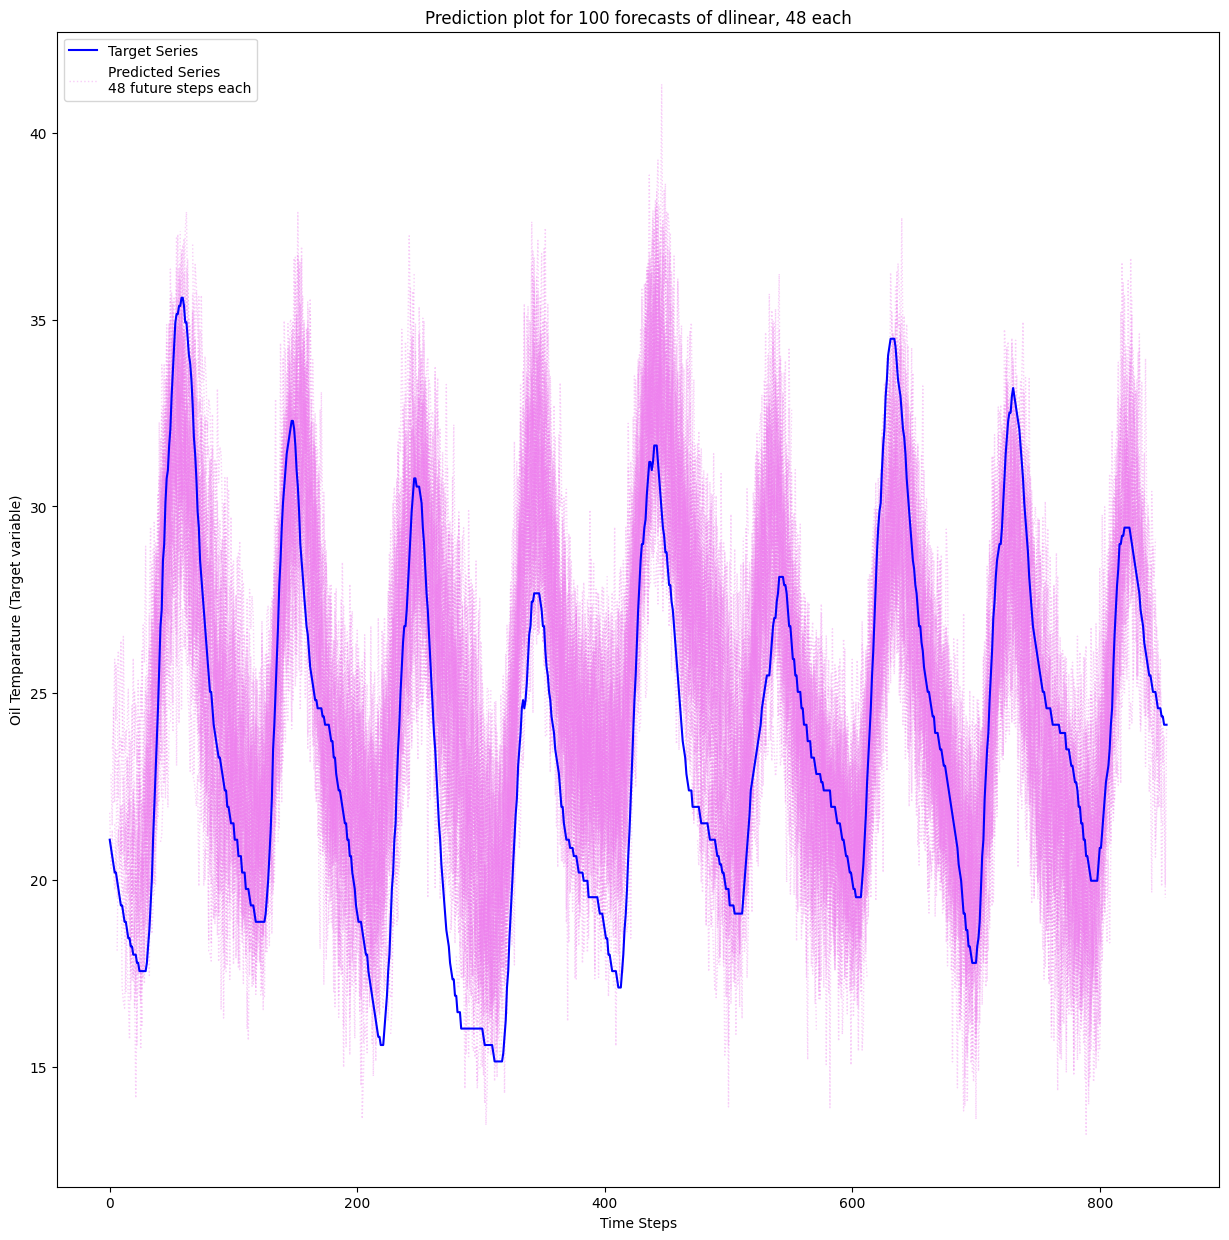

In [6]:
net = train(
            epochs = epochs, 
            n_continous_features=n_continous_features, 
            n_categorial_features=n_categorial_features,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = test_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            model = 'dlinear', 
            modelling_task = modelling_task, 
            dataset_name = dataset_name
            )
test_data = DataLoader(TimeSeriesDataset(test_df, future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, dataset_name = dataset_name, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)

#### RLMP

Random seed set as 42
Univatiate modelling
inflation factor = 1
RMLP activated
Points to be estimated
Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 5000 : 34.15103763961792
Current (running) training loss at iteration 10000 : 26.215125174427033
Current (running) training loss at iteration 15000 : 20.059809621302286
Current (running) training loss at iteration 20000 : 16.20290729264021
Current (running) training loss at iteration 25000 : 14.707261218910217
Current (running) training loss at iteration 30000 : 13.692369370698929
Current (running) training loss at iteration 35000 : 12.857687422520774
Current (running) training loss at iteration 40000 : 11.877322517216205
Current (running) training loss at iteration 45000 : 11.136552448972067

Epoch 0: 

Train metrics: -------
Running (training) loss is 11.04804536592025.
Training MAE is 0.8373628183816467.
Training MSE is 11.115228730946544.

Test metrics: -------
Running (test) loss is 15.51350153931256.
Test MAE is 1.0639137446376994.
Test MSE is 15.592892703625788.
---------------------------
Current learning rate is : 5e-05
------------

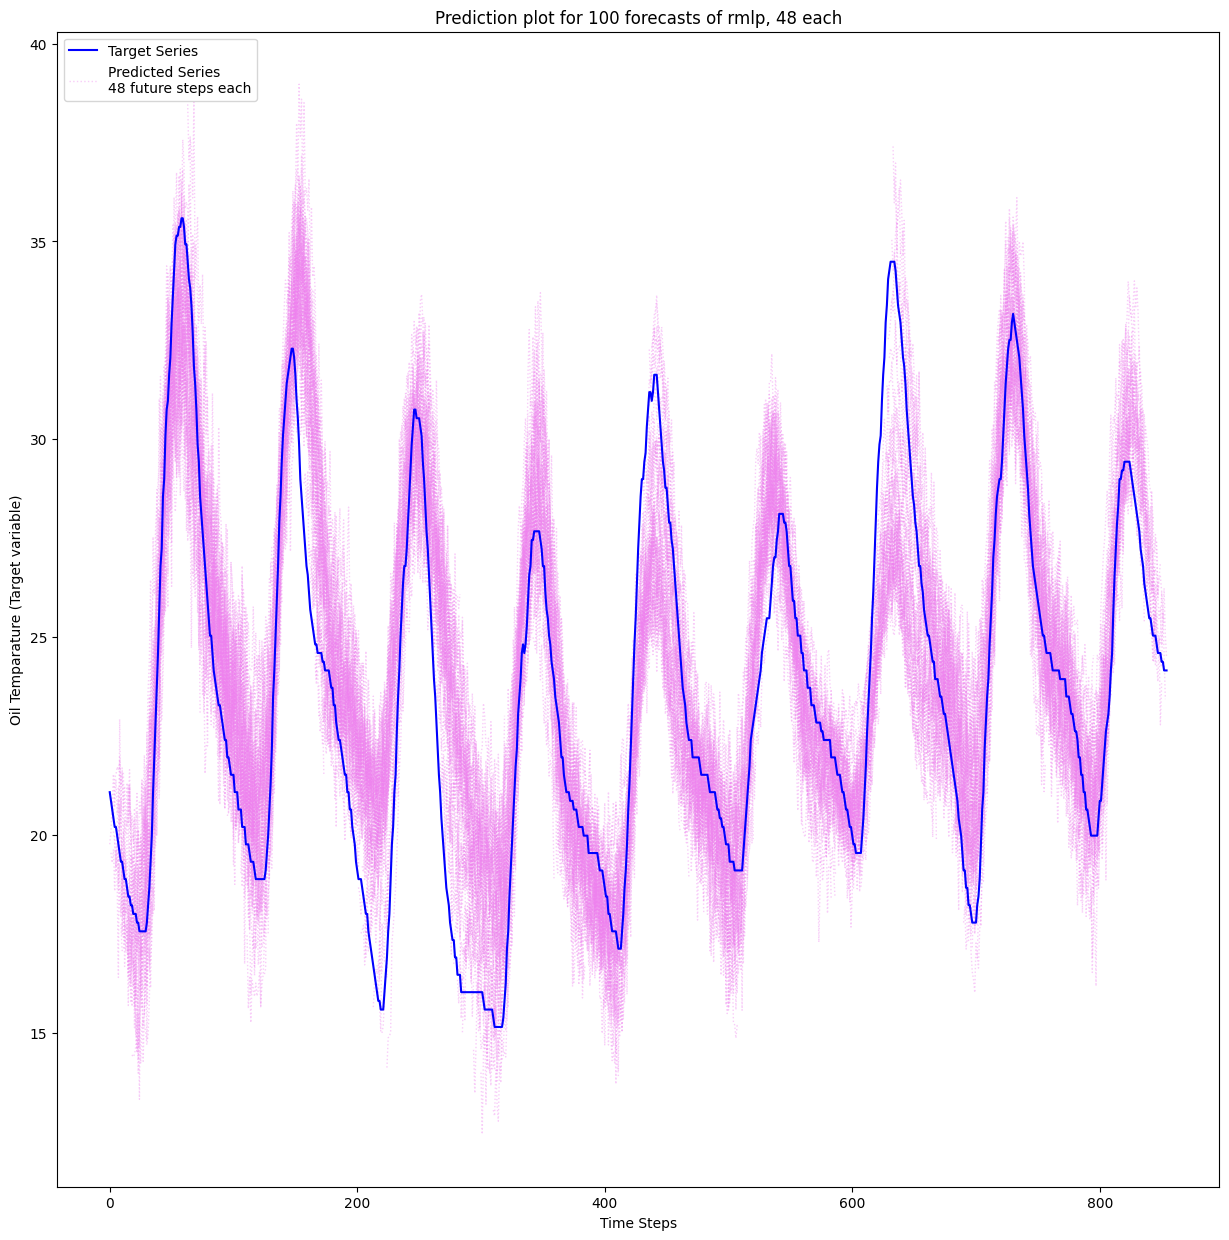

In [7]:
net = train(
            epochs = epochs, 
            n_continous_features=n_continous_features, 
            n_categorial_features=n_categorial_features,
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = test_df, 
            feature_columns = feature_columns,
            target_column = target_column, 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size, 
            model = 'rmlp', 
            modelling_task = modelling_task, 
            dataset_name = dataset_name
            )
test_data = DataLoader(TimeSeriesDataset(test_df, future_steps= future_steps, target_column = target_column,feature_columns=feature_columns,p_lag=p_lag), batch_size=batch_size,drop_last=True)
plot_multistep_forecast(test_data=test_data, dataset_name = dataset_name, neural_net=net, future_steps=future_steps, number_of_forecasts=number_of_forecasts)